In [4]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss

from sklearn.preprocessing import (
    PolynomialFeatures,
    OneHotEncoder
)
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# time-related stack
from datetime import datetime as dt


In [5]:
def plot_series(X, Y, format, start = 0, end = None, title = None, xlabel = None, ylabel = None, legend = None, size = (16,9)):

    plt.figure(figsize = size)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

In [6]:
data = pd.read_csv("../../data/daily_sunspots_time_series_1850-01_2024-05.csv", parse_dates=['date'])
data.set_index('date', inplace = False)

,year,month,day,date_frac,counts,std,nobs,indicator
date,,,,,,,,
1850-01-01,1850,1,1,1850.001,253,19.6,1,NaN
1850-01-02,1850,1,2,1850.004,162,15.5,1,NaN
1850-01-03,1850,1,3,1850.007,217,18.1,1,NaN
1850-01-04,1850,1,4,1850.010,99,12.0,1,NaN
1850-01-05,1850,1,5,1850.012,108,12.6,1,NaN
...,...,...,...,...,...,...,...,...
2024-04-26,2024,4,26,2024.318,141,29.9,30,*
2024-04-27,2024,4,27,2024.321,139,25.9,29,*
2024-04-28,2024,4,28,2024.324,119,22.0,25,*


## EDA

In [7]:
data.info()
data.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63673 entries, 0 to 63672
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       63673 non-null  datetime64[ns]
 1   year       63673 non-null  int64         
 2   month      63673 non-null  int64         
 3   day        63673 non-null  int64         
 4   date_frac  63673 non-null  float64       
 5   counts     63673 non-null  int64         
 6   std        63673 non-null  float64       
 7   nobs       63673 non-null  int64         
 8   indicator  121 non-null    object        
dtypes: datetime64[ns](1), float64(2), int64(5), object(1)
memory usage: 4.4+ MB


,count,mean,min,25%,50%,75%,max,std
date,63673,1937-03-02 00:00:00,1850-01-01 00:00:00,1893-08-01 00:00:00,1937-03-02 00:00:00,1980-09-30 00:00:00,2024-04-30 00:00:00,NaN
year,63673.0,1936.666515,1850.0,1893.0,1937.0,1980.0,2024.0,50.325569
month,63673.0,6.515383,1.0,4.0,7.0,10.0,12.0,3.45023
day,63673.0,15.729147,1.0,8.0,16.0,23.0,31.0,8.79993
date_frac,63673.0,1937.165879,1850.001,1893.582,1937.166,1980.747,2024.329,50.325293
counts,63673.0,83.410174,0.0,21.0,64.0,128.0,528.0,76.875804
std,63673.0,7.084788,0.0,3.4,6.6,9.9,77.7,4.494376
nobs,63673.0,6.00212,1.0,1.0,1.0,1.0,69.0,10.018833


In [8]:
data = data.drop('indicator', axis = 1)

In [9]:
(data.counts == 0).sum()

9344

<function matplotlib.pyplot.show(close=None, block=None)>

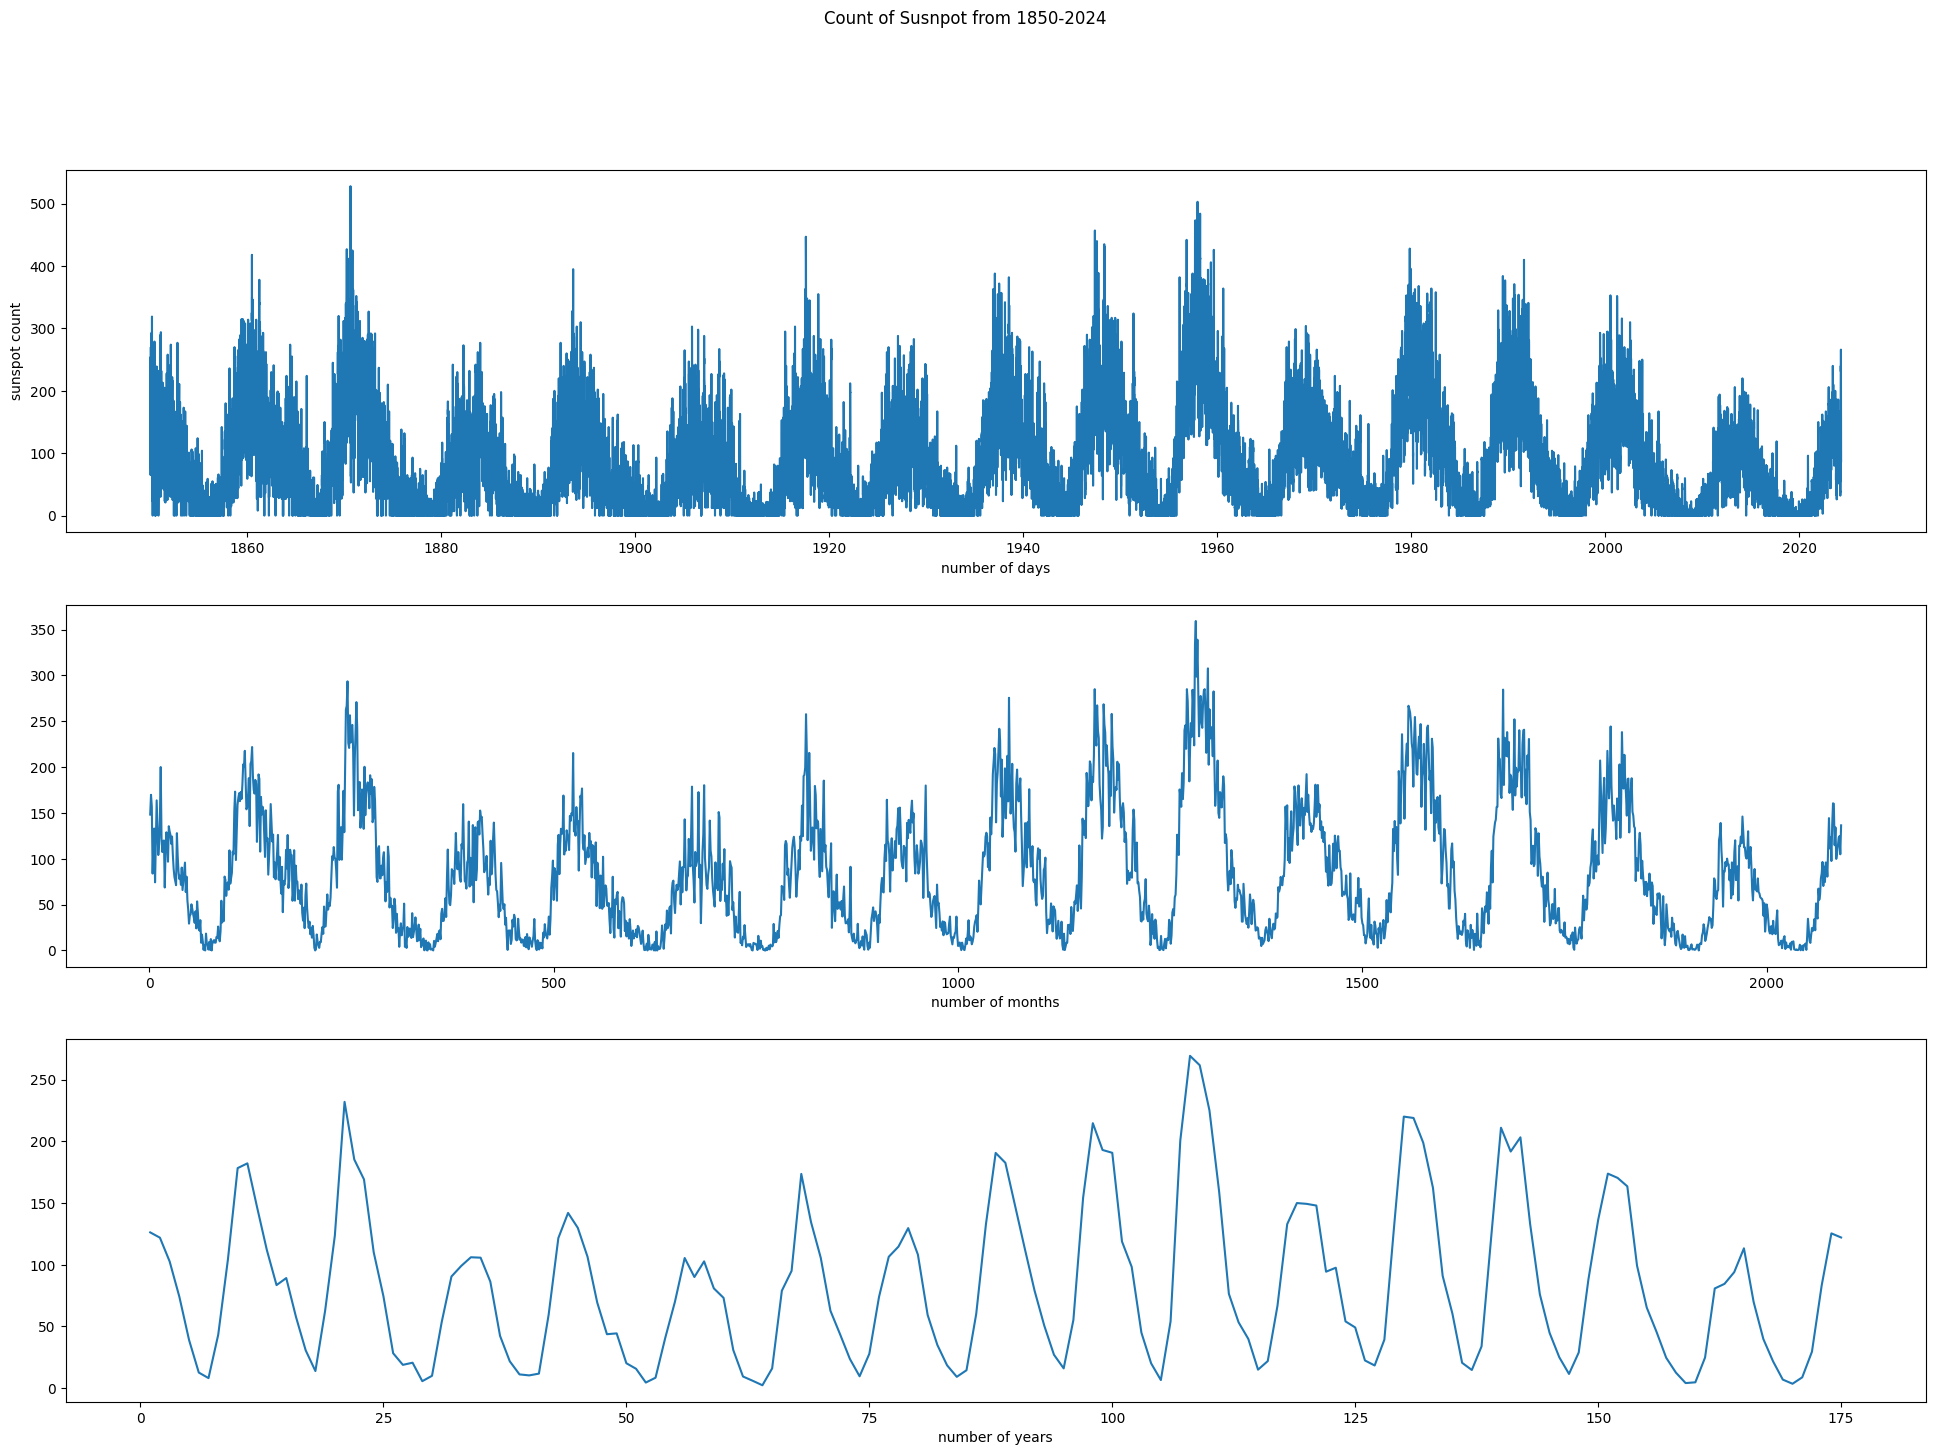

In [10]:
daily = data.resample('D', on = 'date').mean()
monthly = data.resample('M', on = 'date').mean()
yearly = data.resample('Y', on = 'date').mean()

n_months = np.linspace(1, monthly.shape[0], monthly.shape[0])
n_years = np.linspace(1, yearly.shape[0], yearly.shape[0])

fig, axs = plt.subplots(3,1, figsize = (24,16))
fig.suptitle('Count of Susnpot from 1850-2024')
axs[0].plot(data.date, data.counts)
axs[0].set_xlabel('number of days')
axs[0].set_ylabel('sunspot count')
axs[1].plot(n_months, monthly.counts)
axs[1].set_xlabel('number of months')
axs[2].plot(n_years, yearly.counts)
axs[2].set_xlabel('number of years')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

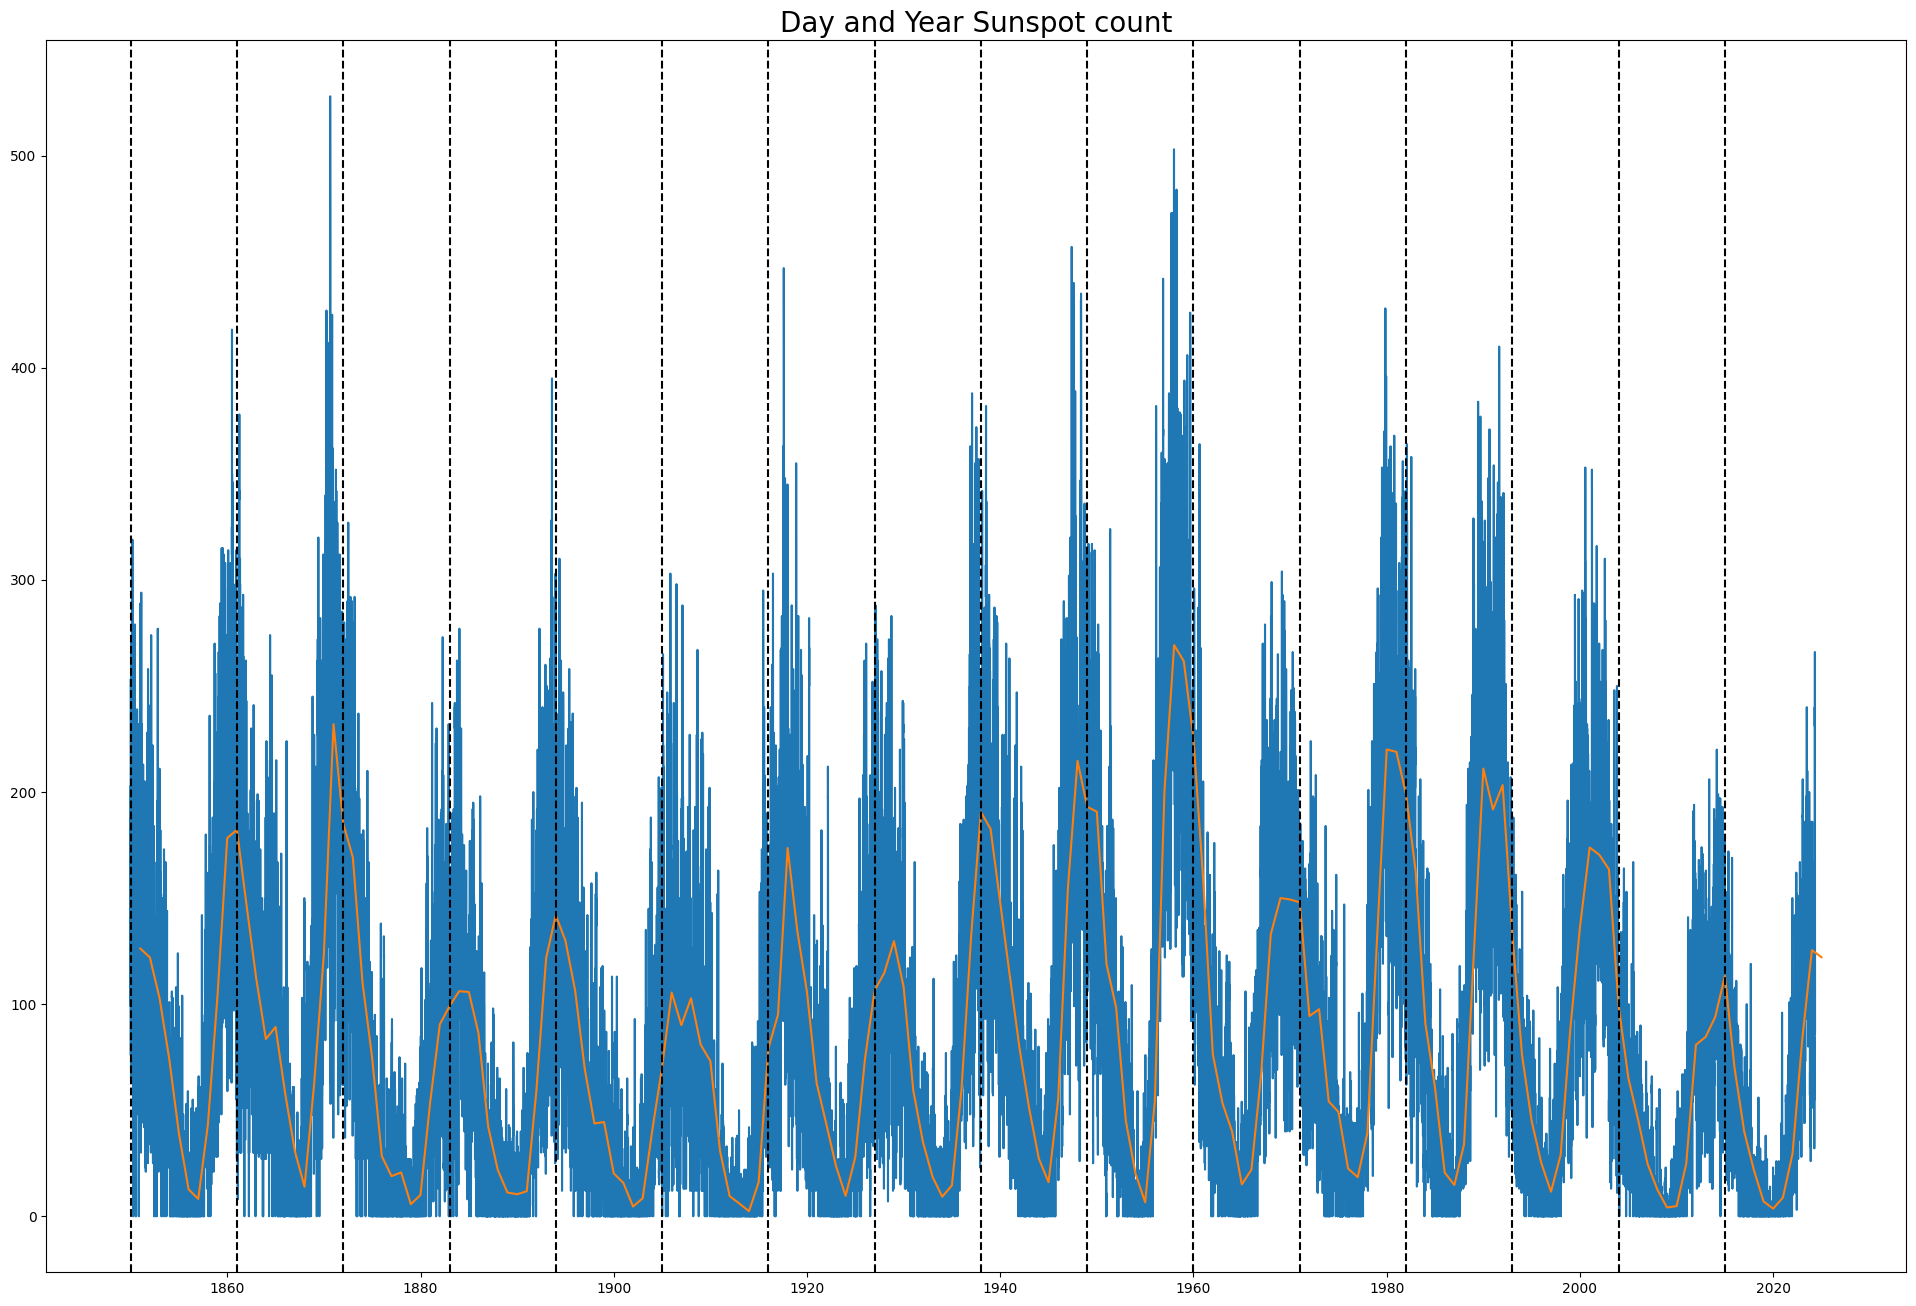

In [29]:
fig = plt.figure(figsize=(24,16))
plt.plot(data.date, data.counts,  yearly.counts)
plt.title('Day and Year Sunspot count', fontsize = 20)
for year in range(1850, 2024, 11):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color = 'k', linestyle= '--', )
plt.show

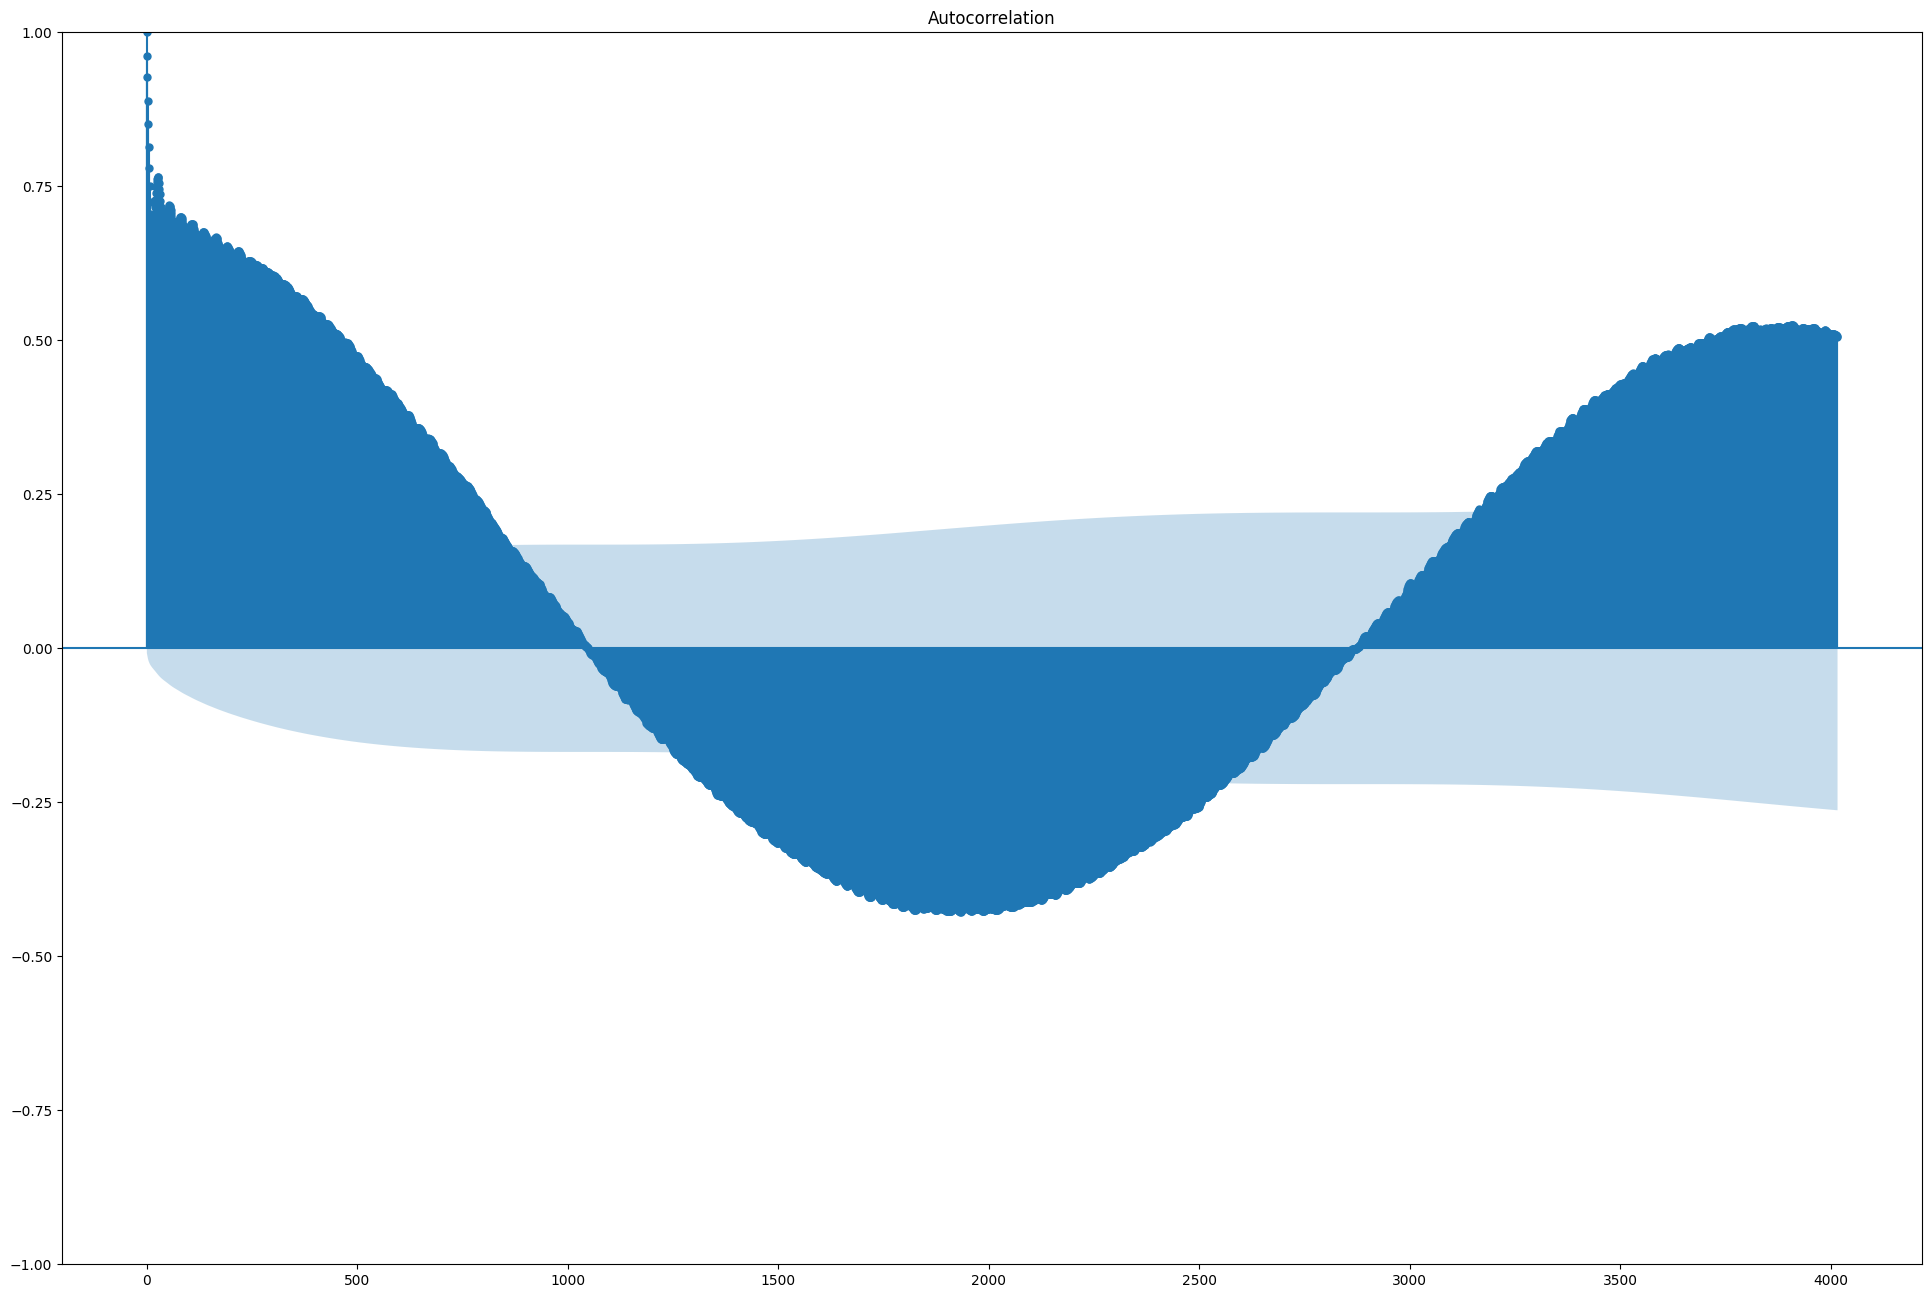

In [39]:
acf_plot = plot_acf(data.counts, lags = 11*365)
acf_plot.set_size_inches((24, 16))
plt.show()

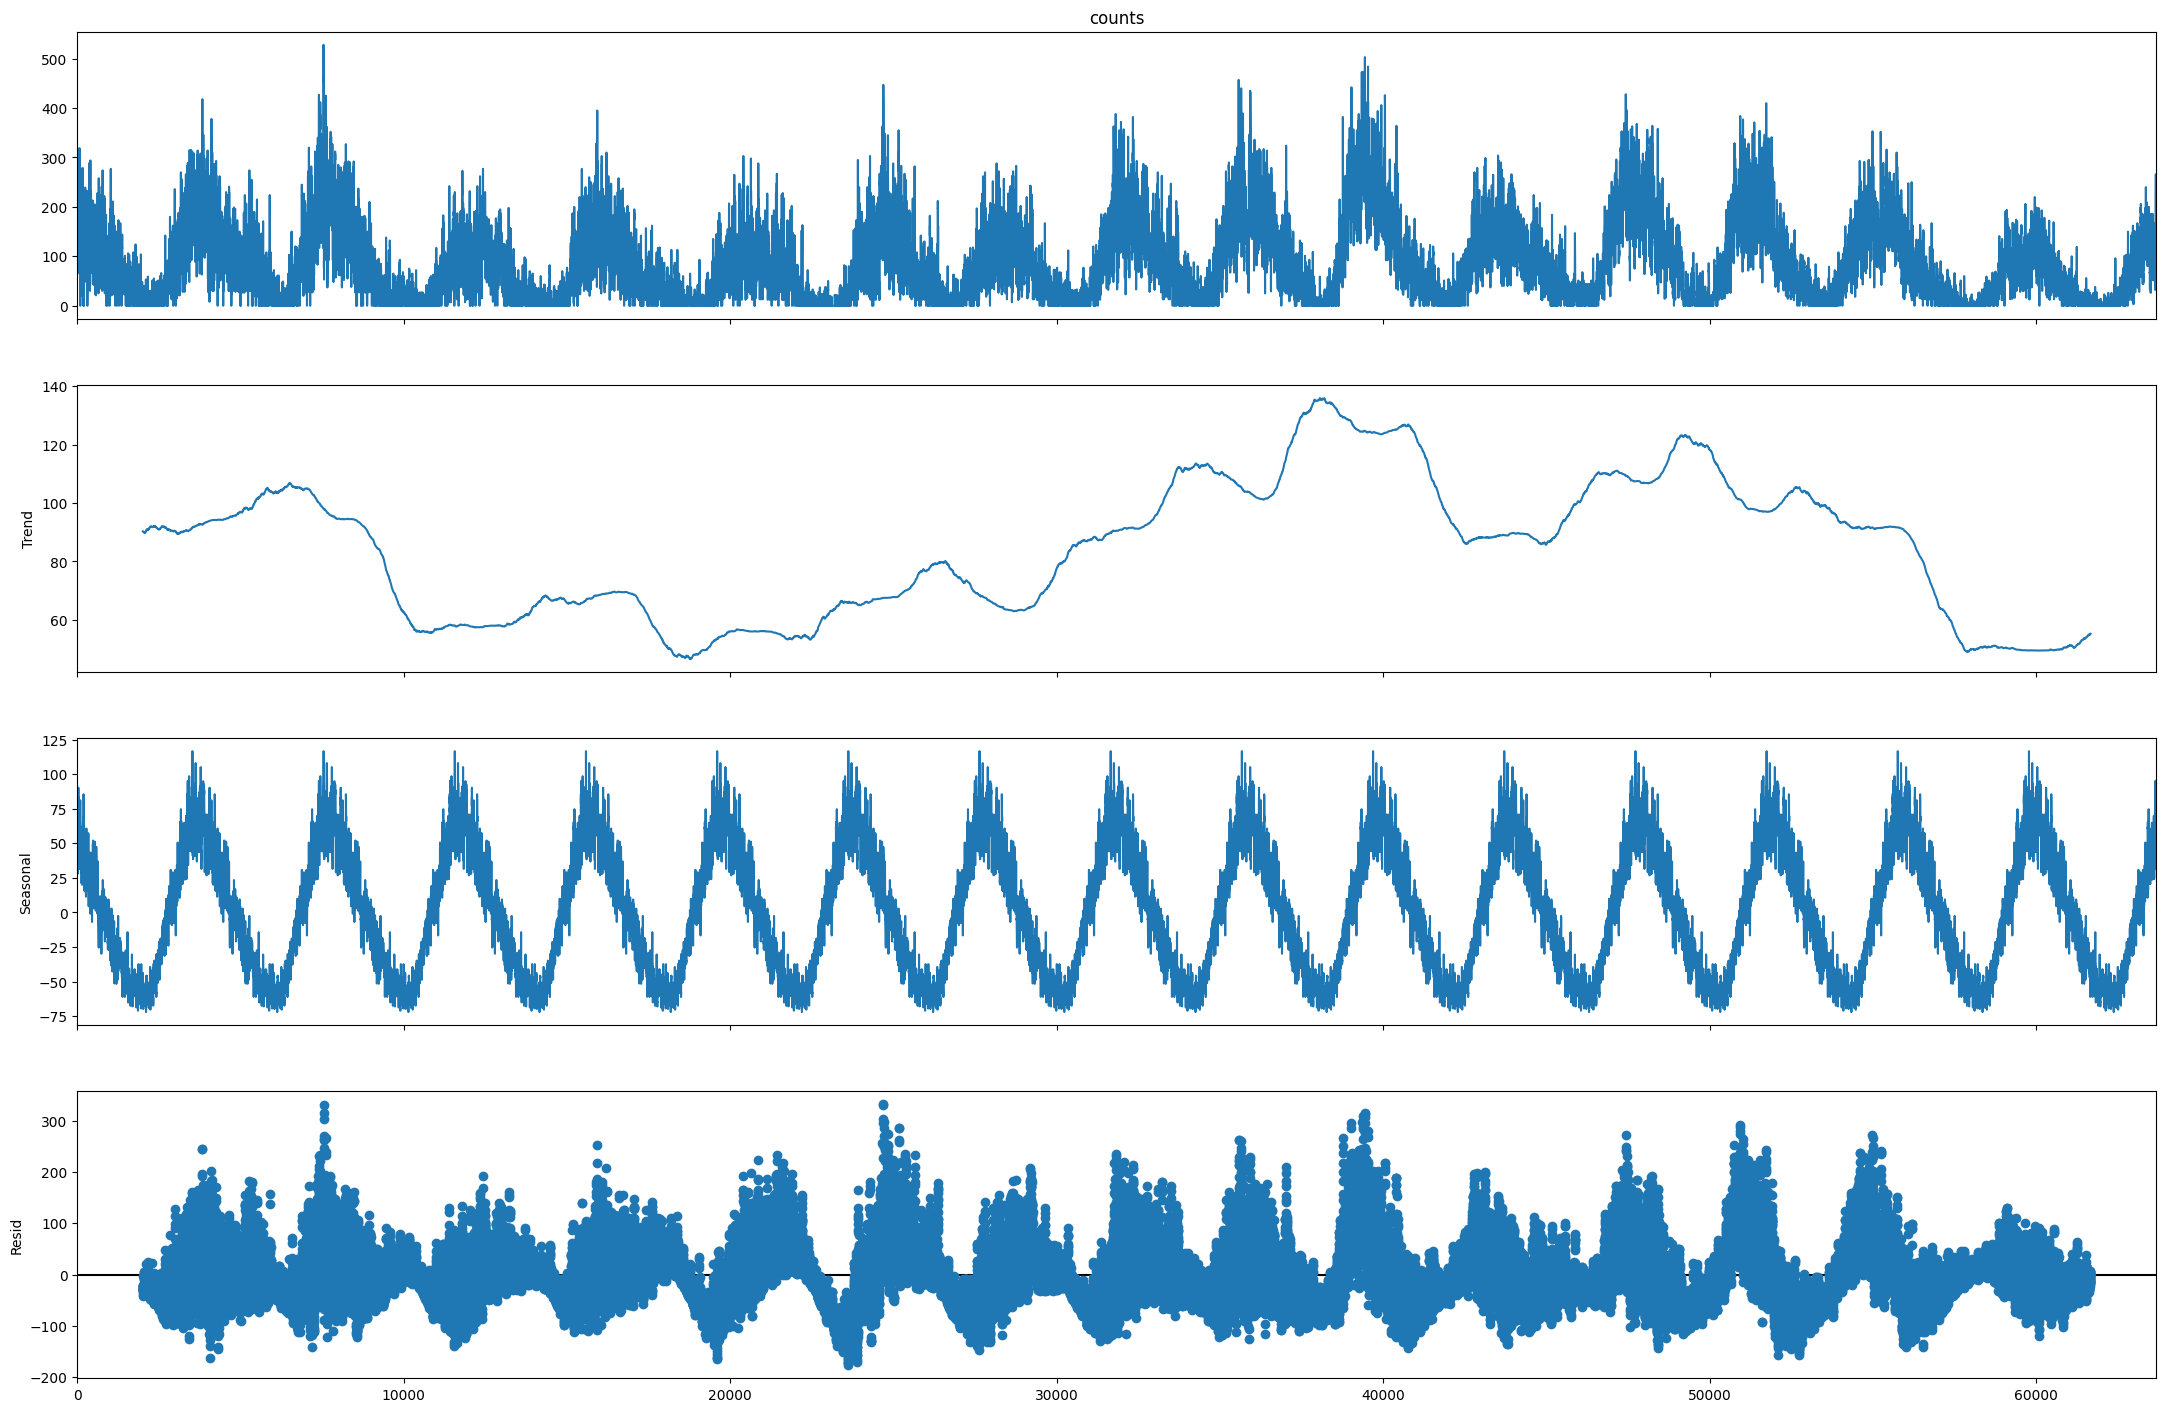

In [40]:
decomposition = seasonal_decompose(data.counts, model = 'add', period = 4018) # Solar cycle 11 years ~ 4015 + 11//4 days
fig = decomposition.plot()
fig.set_size_inches((24, 16))
plt.show()

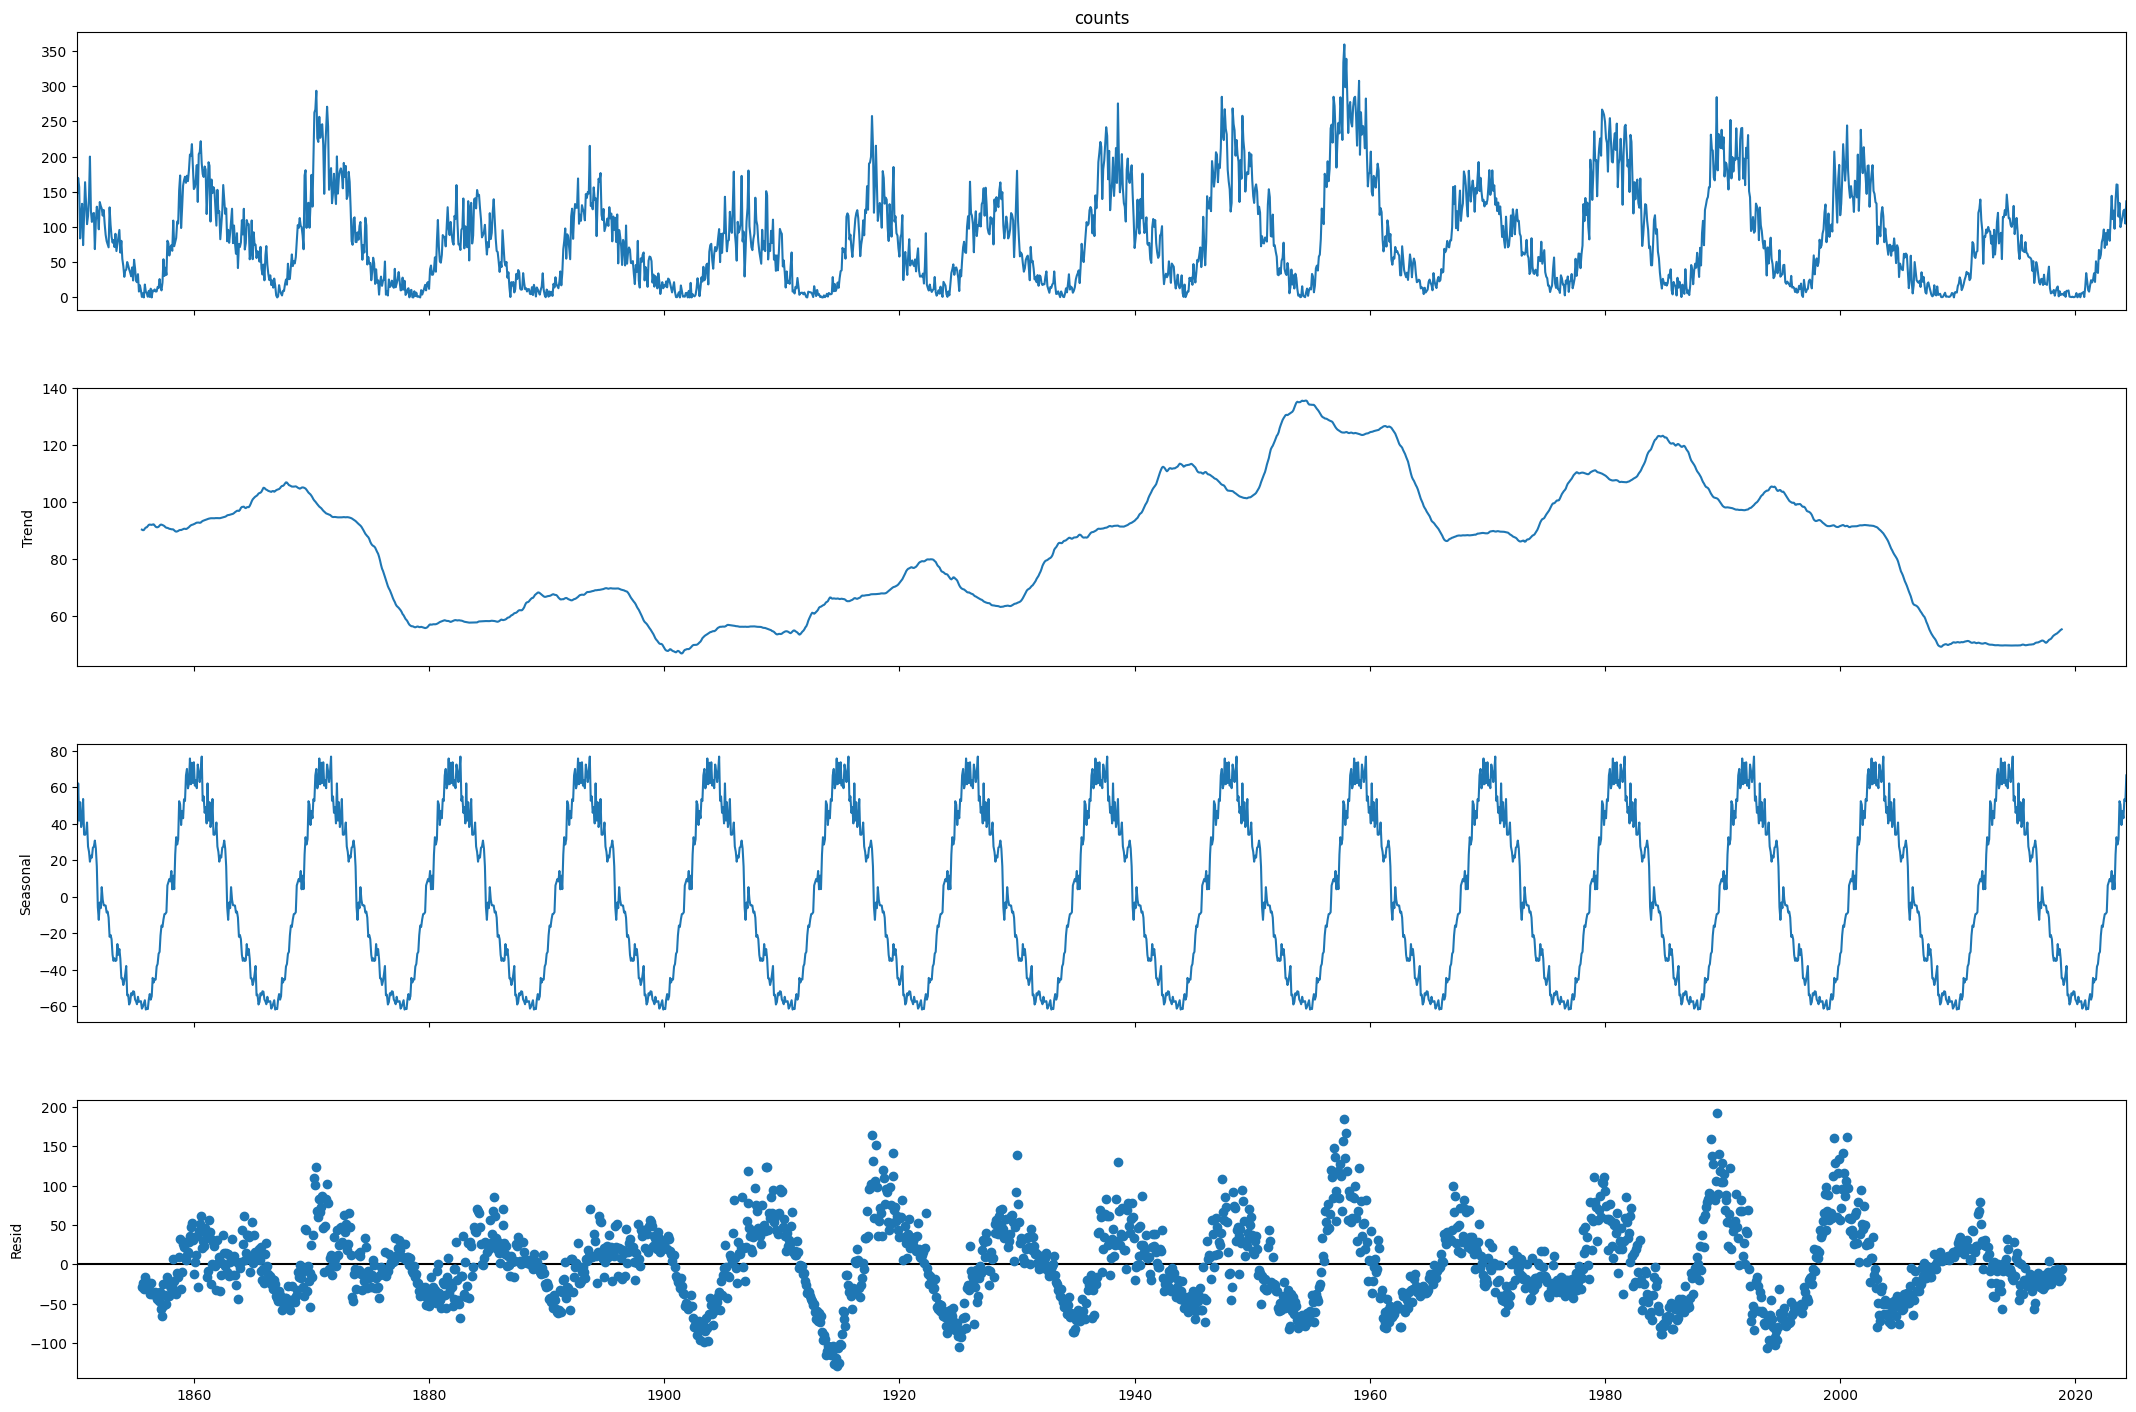

In [42]:
decomposition_month = seasonal_decompose(monthly.counts, model = 'add', period = 132) # Solar cycle 11 years ~ 4015 + 11//4 days
fig = decomposition_month.plot()
fig.set_size_inches((24, 16))
plt.show()

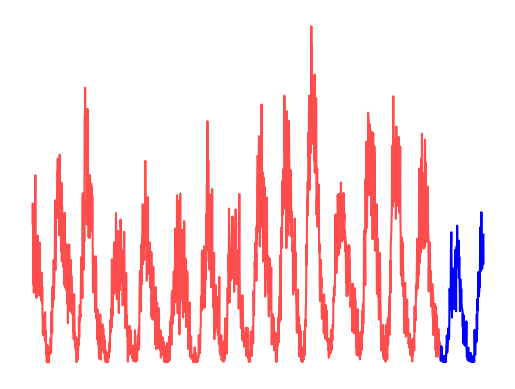

In [20]:

fig, ax = plt.subplots()  
# Plot the first segment of the line in red 
ax.plot(n_months[0:-200], monthly.counts[0:-200], color='red', alpha = 0.7) 
# Plot the second segment of the line in blue 
ax.plot(n_months[len(n_months)-200:], monthly.counts[len(n_months)-200:], color='blue') 
ax.axis('off')
plt.show() 


